This notebook demonstrates how to continuously emulate the behavior of a discrete hysteresis element.

It uses a combination of a linear-first-order-element ("PT1") and a $\tanh(\cdot)$-function.

It also contains a very rough prototype for how to automatically visualize `pyblocksim`-models.

In [1]:
import time
print(time.ctime())
%load_ext ipydex.displaytools

Tue Dec 14 00:12:05 2021


In [2]:
import numpy as np
import sympy as sp
from matplotlib import pyplot as plt

import pyblocksim as pbs
s = pbs.s # Laplace-Variable

In [3]:
# switching tresholds for hysteresis
x1 = 4  # switching down
x2 = 8  # switching up

# output values of the hysteresis system
y1 = 2
y2 = 14

# time constant of the internal linear-first-order (PT1)
T_storage = 1e-4

In [4]:
def step_factory(y0, y1, x_step=0, tanh_scaling_factor=1e3):
    """
    Factory to create continously approximated step functions.
    
    :param y0:       start value of the step function
    :param y1:       final value of the step function
    :param x_step:   x-value at which the step occurs
                     (better: middle point of the step). 
    
    :param tanh_scaling_factor:
                     scaling of shifted x-value, such that the tanh-func
                     becomes more rectangular for bigger values. Default 1e3
    
    """
    # tanh maps R to (-1, 1)

    # first map R to (0, 1)
    # then map (0, 1) -> (y0, y1)

    dy = y1-y0

    def fnc(x, module=sp):
        """
        The step function (depends on external variables x_step, dy and y0).
        
        :param x:       argument of the step function
        :param module:  module object from which to take the tanh-func (numpy or sympy)
        """
        
        z1 = tanh_scaling_factor*(x-x_step)  # shift and scale x-axis
        z2 = module.tanh(z1)  # map z1 ∈ (-inf, inf) to interval (-1, 1)
        z3 = (z2 +1 )/2  # map z2 ∈ (-1, 1) to (0, 1)
        z4 = z3*dy + y0  # map z3 ∈ (0, 1) to (y0, y1)
        
        return z4

    # save docstring and step parameters
    fnc.__doc__ = "approximated step function %f, %f, %f" % (y0, y1, x_step)
    fnc.x_step = x_step
    fnc.y0 = y0
    fnc.y1 = y1
    fnc.tanh_scaling_factor = tanh_scaling_factor

    return fnc

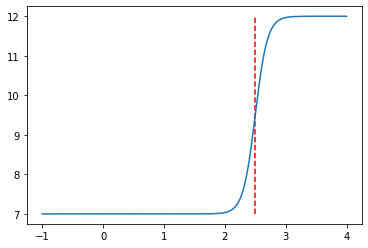

In [5]:
# Visualize smoothed step-function

# for demo purpose the tanh_scaling_factor is choosen very small here
demo_step = step_factory(y0=7, y1=12, x_step=2.5, tanh_scaling_factor=5)

xx = np.linspace(-1, 4, 1000)
yy = demo_step(xx, module=np)

plt.plot(xx, yy)

# vertical line
plt.vlines([demo_step.x_step], demo_step.y0, demo_step.y1, color="r", ls="--")

This function can now be used to continuously approximate static functions with jump discontinuities.

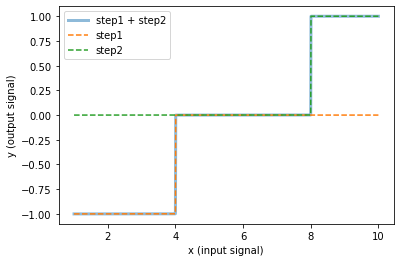

In [6]:
# define two step functions whose sum is used as a three-point-element
step1 = step_factory(-1, 0, x1)
step2 = step_factory(0, 1, x2)


# visualize this sum
xx = np.linspace(1, 10, int(1e5))

plt.plot(xx, step1(xx, np) + step2(xx, np), lw=3, label="step1 + step2", alpha=0.5)
plt.plot(xx, step1(xx, np), "--", label="step1")
plt.plot(xx, step2(xx, np), "--", label="step2")
plt.legend()
plt.xlabel("x (input signal)")
plt.ylabel("y (output signal)");

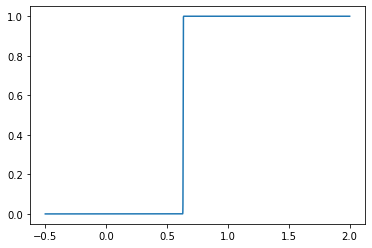

In [7]:
# define a third step-function which will limits the input of the memory-PT1 between between 0 and 1
# its jump location is approx. 0.63 (special value of PT1)
time_const_value = 1 - np.exp(-1) # approx 0.63
step3 = step_factory(0, 1, time_const_value)

xx = np.linspace(-0.5, 2, int(1e5))
plt.plot(xx, step3(xx, np))

Now we create the blocks and linkt them together as shown in this diagram (which is automatically created below):


<img src="blockdiag.svg">


Note: For technical reasons the numerator and the denominator of transferfunctions are depicted as separate blocks.

In [8]:
hyst_in, fb = pbs.inputs('hyst_in, fb') # overall input of hysteresis and internal feedback
# the feedback signal will be connected later to the output of a block yet to be defined


# the sum of the two step-functions (≙ three-point-controller) + feedback signal
SUM1 = pbs.Blockfnc(step1(hyst_in) + step2(hyst_in) + fb)

# restrict the output of this sum to values in [0, 1]
LIMITER = pbs.Blockfnc(step3(SUM1.Y))

# define the memory block as PT1 with gain = 1 and time constant `T_storage`
# its input is ∈ [0, 1], thus its output also is ∈ [0, 1]
PT1_storage = pbs.TFBlock(1/(T_storage*s + 1), LIMITER.Y)

# close the loop: connect PT1-output with fb-signal
pbs.loop(PT1_storage.Y, fb)

# Note, this is the main idea of this approach:
# The PT1 is very fast, its output is either 0 or 1.
# The feeback of the "1-output" ensures that the input of the PT1 remains 1
# if the output of the three-point-element is at least 0.

# Once the output of the three-point-element is -1 the combined output of `SUM1` is 0.
# The PT1 gets 0 at the input and its output rapidly falls to 0.
# Then we have a feedback of the "0-output" and thus the output of `SUM1` is -1
# But due to the LIMITER element the input of the PT1 is still 0

# The state (and the output) of the PT1 only shifts from 0 to 1 if the output of the
# three-point-element is 1.


# Final block: scale and offset for the output to achieve mapping from [0, 1] to [y1, y2]
Result_block = pbs.Blockfnc(PT1_storage.Y*(y2-y1) + y1)



In [9]:
def input_ramps(t):

    T1 = 10
    T2 = 20
    k1 = 1
    k2 = 1

    if t < 0:
        return 0
    elif t < T1:
        return k1*t
    elif t < T2:
        return k1*T1 - k2*(t-T1)
    else:
        return 0


In [10]:
# perform the simulation
tt, states = pbs.blocksimulation(25, {hyst_in: input_ramps}) # simulate
tt = tt.flatten()

# compute the outputs from the trajectories of the state-components
bo = pbs.compute_block_ouptputs(states)

# recalculate the input-signal (for visualization)
input_signal = [input_ramps(t) for t in tt]


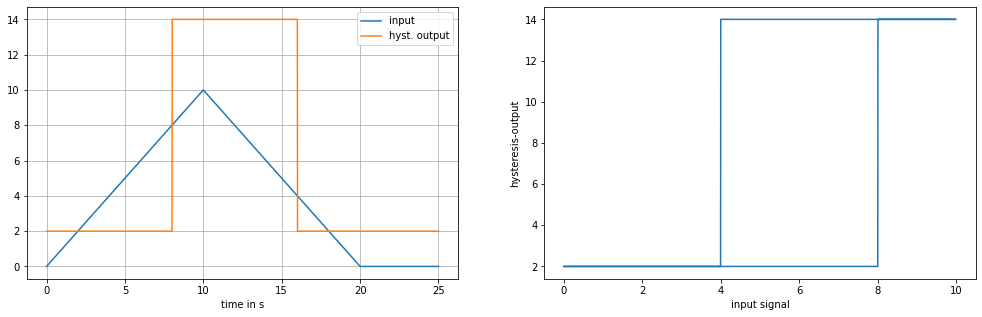

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5));
plt.sca(ax1)  # set current axis

plt.plot(tt, input_signal, label='input')
plt.plot(tt, bo[Result_block], label='hyst. output')
plt.xlabel('time in s')

plt.grid(1)
plt.legend()

plt.sca(ax2)  # set current axis
plt.plot(input_signal, bo[Result_block])
plt.xlabel('input signal')
plt.ylabel('hysteresis-output')

plt.show()

The hysteresis element works as expected: The output jumps from $y_1=2$ to $y_2=14$ as soon as the input rises above $x_1=8$. The output jumps back to  $y_1=2$, as soon as the input falls below $x_2=4$.

The values of $x_1, x_2, y_1, y_2$ are defined above at the beginning of the notebook.

---

## Render blockdiagram

The following code is not directly related to simulating the hysteresis element. However, it is needed to produce the illustrative blockdiagram above and thus is indirectly realated to the hysteresis problem.

In [13]:

from blockdiag import parser, builder, drawer
from IPython.display import SVG, display

def render_bdiag(source):
    # source: https://stackoverflow.com/a/67819592/333403

    tree = parser.parse_string(source)
    diagram = builder.ScreenNodeBuilder.build(tree)
    draw = drawer.DiagramDraw('svg', diagram, filename="blockdiag.svg")
    draw.draw()
    svg_source = draw.save()
    display(SVG(svg_source))


In [14]:
pbs.theStateAdmin.allBlockNames

OrderedDict([('SUM1', Blockfnc:SUM1),
             ('LIMITER', Blockfnc:LIMITER),
             ('PT1_storage_denom', IBlock:PT1_storage_denom),
             ('PT1_storage_num', NILBlock:PT1_storage_num),
             ('PT1_storage', TFBlock:PT1_storage),
             ('Result_block', Blockfnc:Result_block)])

In [15]:
aa = pbs.theStateAdmin

In [16]:
real_inputs = [sig for sig in aa.inputs if sig not in aa.loops]

In [17]:
def nodevar_generator():
    for i in range(26):
        yield chr(ord("A")+i)

In [18]:
# We have one loop: fb = Y03
aa.loops

OrderedDict([(fb, Y03)])

In [19]:
# create nodes
nodevar = nodevar_generator()
nodes = [(sig, (next(nodevar), f"System Input {i}", None)) for i, sig in enumerate(real_inputs)]
nodes += [(block.Y, (next(nodevar), block.name, block)) for i, block in enumerate(aa.allBlocks.values())]
signal_node_map = dict(nodes) ##:

signal_node_map := {hyst_in: ('A', 'System Input 0', None),
 Y00: ('B', 'SUM1', Blockfnc:SUM1),
 Y01: ('C', 'LIMITER', Blockfnc:LIMITER),
 Y02: ('D', 'PT1_storage_denom', IBlock:PT1_storage_denom),
 Y03: ('F', 'PT1_storage', TFBlock:PT1_storage),
 Y04: ('G', 'Result_block', Blockfnc:Result_block)}

---

In [20]:
connections = []

for block in aa.allBlocks.values():
    # TODO: all block should have an interface for this
    # Blockfunctions have multiple inputs (sums, products, etc), they are called .symbs
    block_inputs = getattr(block, "symbs", None)
    
    # other blocks only have one input (called .X)
    if block_inputs is None:
        block_inputs = [block.X]
        
    target_nodevar = signal_node_map[block.Y][0]
        
    for bi in block_inputs:
        
        value = signal_node_map.get(bi)
                
        if value:
            source_nodevar, label, source_block = value
            connections.append((source_nodevar, target_nodevar))
        
        
        if bi in aa.loops:
            sig2 = aa.loops[bi]
            value = signal_node_map.get(sig2)
            if value:
                source_nodevar, label, source_block = value
                connections.append((source_nodevar, target_nodevar))



In [21]:
nodes_doc = "\n    ".join([f'{v[0]} [label = "{v[1]}"];' for v in signal_node_map.values()])
edges_doc = "\n    ".join([f'{c[0]} -> {c[1]};' for c in connections])

bdiag_doc = f"""
blockdiag {{
    // nodes
    {nodes_doc}
   
    // edges
    {edges_doc}
}}
"""

In [22]:
print(bdiag_doc)


blockdiag {
    // nodes
    A [label = "System Input 0"];
    B [label = "SUM1"];
    C [label = "LIMITER"];
    D [label = "PT1_storage_denom"];
    F [label = "PT1_storage"];
    G [label = "Result_block"];

    // edges
    A -> B;
    F -> B;
    B -> C;
    C -> D;
    D -> F;
    C -> F;
    F -> G;
}



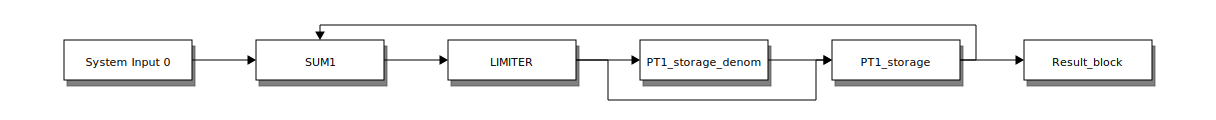

In [23]:
render_bdiag(bdiag_doc)

In [24]:
connections

[('A', 'B'),
 ('F', 'B'),
 ('B', 'C'),
 ('C', 'D'),
 ('D', 'F'),
 ('C', 'F'),
 ('F', 'G')]